    sepal_length  sepal_width  petal_length  petal_width            type
1            5.1          3.5           1.4          0.2     Iris-setosa
2            4.9          3.0           1.4          0.2     Iris-setosa
3            4.7          3.2           1.3          0.2     Iris-setosa
4            4.6          3.1           1.5          0.2     Iris-setosa
5            5.0          3.6           1.4          0.2     Iris-setosa
..           ...          ...           ...          ...             ...
76           6.4          3.2           5.3          2.3  Iris-virginica
77           6.5          3.0           5.5          1.8  Iris-virginica
78           7.7          3.8           6.7          2.2  Iris-virginica
79           7.7          2.6           6.9          2.3  Iris-virginica
80           6.0          2.2           5.0          1.5  Iris-virginica

[80 rows x 5 columns]
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 

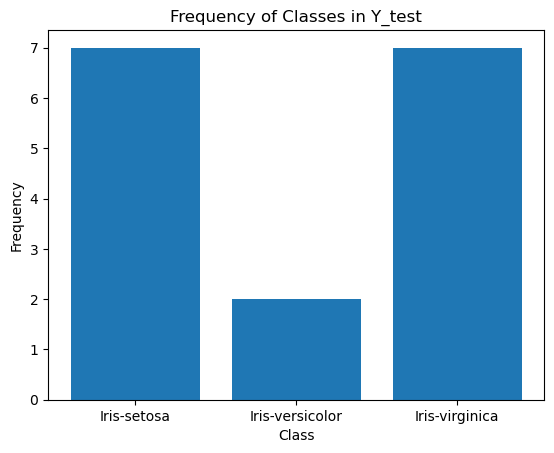

In [19]:
import pandas as pd
import pydot

#getting the data
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("iris_imbalance.csv", skiprows=1, header=None, names=col_names)
data.head(10)
print(data)

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value
        
class DecisionTreeClassifier():

    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X = [sample[:-1] for sample in dataset]
        Y = [sample[-1] for sample in dataset]

        num_samples = len(X)
        num_features = len(X[0])  # Assuming all samples have the same number of features

        
        # split until stopping conditions are met
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"] > 0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
            
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -9999
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = [sample[feature_index] for sample in dataset]
            possible_thresholds = sorted(set(feature_values))  # Use sorted set to get unique values
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if children are not null
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y = [sample[-1] for sample in dataset]
                    left_y = [sample[-1] for sample in dataset_left]
                    right_y = [sample[-1] for sample in dataset_right]

                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = [sample for sample in dataset if sample[feature_index] <= threshold]

        dataset_right = [sample for sample in dataset if sample[feature_index] > threshold]
        
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="gini"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        
        
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_counts = {}
        for value in y:
            if value in class_counts:
                class_counts[value] += 1
            else:
                class_counts[value] = 1
                
        entropy = 0
        total_samples = len(y)
        for class_count in class_counts.values():
            p_cls = class_count / total_samples
            entropy += -p_cls * math.log2(p_cls)

        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_counts = {}
        for value in y:
            if value in class_counts:
                class_counts[value] += 1
            else:
                class_counts[value] = 1
                
        gini = 1
        total_samples = len(y)
        for class_count in class_counts.values():
            p_cls = class_count / total_samples
            gini -= p_cls ** 2
            
        return gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y_counts = {}
        for value in Y:
            if value in Y_counts:
                Y_counts[value] += 1
            else:
                Y_counts[value] = 1
                
        max_count = -1
        max_value = None
        for value, count in Y_counts.items():
            if count > max_count:
                max_count = count
                max_value = value
                
        return max_value
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print(col_names[tree.feature_index], "<=", tree.threshold, "Info gain:", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
            
    def save_tree_as_dot(self, filename="decision_tree.dot", tree=None):
        ''' function to save the decision tree as a DOT file '''

        if not tree:
            tree = self.root

        with open(filename, "w") as dotfile:
            dotfile.write("digraph DecisionTree {\n")
            self._generate_dot(tree, dotfile)
            dotfile.write("}\n")

    def _generate_dot(self, tree, dotfile, parent_node=None):
        ''' recursive function to generate DOT format text for the tree '''

        if tree.value is not None:
            node_label = str(tree.value)
        else:
            node_label = col_names[tree.feature_index] + " <= " + str(tree.threshold) + "\\nInfo gain: " + str(tree.info_gain)

        dotfile.write('  "{}" [label="{}"];\n'.format(id(tree), node_label))

        if parent_node is not None:
            dotfile.write('  "{}" -> "{}";\n'.format(id(parent_node), id(tree)))

        if tree.left:
            self._generate_dot(tree.left, dotfile, tree)

        if tree.right:
            self._generate_dot(tree.right, dotfile, tree)

    
    def fit(self, X, Y):
        ''' function to train the tree '''
        

        dataset = [list(x) + [y[0]] for x, y in zip(X, Y)]
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)



X = data.iloc[:, :-1].values
print(X)
Y = data.iloc[:, -1].values.reshape(-1, 1)

import random
def custom_train_test_split(X, Y, test_size=0.2, random_state=None):
    if random_state is not None:
        random.seed(random_state)

    num_samples = len(X)
    num_test = int(test_size * num_samples)

    indices = list(range(num_samples))
    random.shuffle(indices)

    test_indices = indices[:num_test]
    train_indices = indices[num_test:]

    X_train = [X[i] for i in train_indices]
    Y_train = [Y[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    Y_test = [Y[i] for i in test_indices]

    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = custom_train_test_split(X, Y, test_size=.2, random_state=41)
import matplotlib.pyplot as plt
import numpy as np


unique_classes, class_counts = np.unique(Y_test, return_counts=True)


plt.bar(unique_classes, class_counts)


plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Classes in Y_test')


plt.show()


In [20]:
import random

def custom_bootstrap_split(X, Y, num_splits=5, random_state=None):
    if random_state is not None:
        random.seed(random_state)

    num_samples = len(X)
    split_size = num_samples // num_splits

    indices = list(range(num_samples))
    random.shuffle(indices)

    split_indices = [indices[i * split_size:(i + 1) * split_size] for i in range(num_splits)]

    X_splits = []
    Y_splits = []

    for split_idx in split_indices:
        X_split = [X[i] for i in split_idx]
        Y_split = [Y[i] for i in split_idx]
        X_splits.append(X_split)
        Y_splits.append(Y_split)

    return X_splits, Y_splits


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

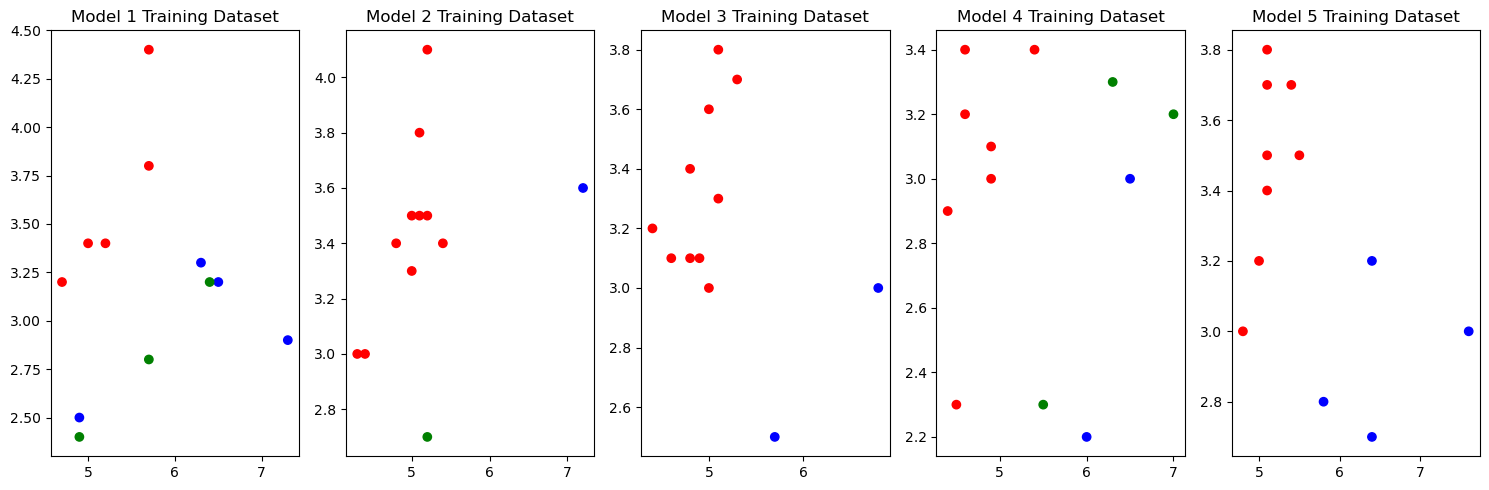

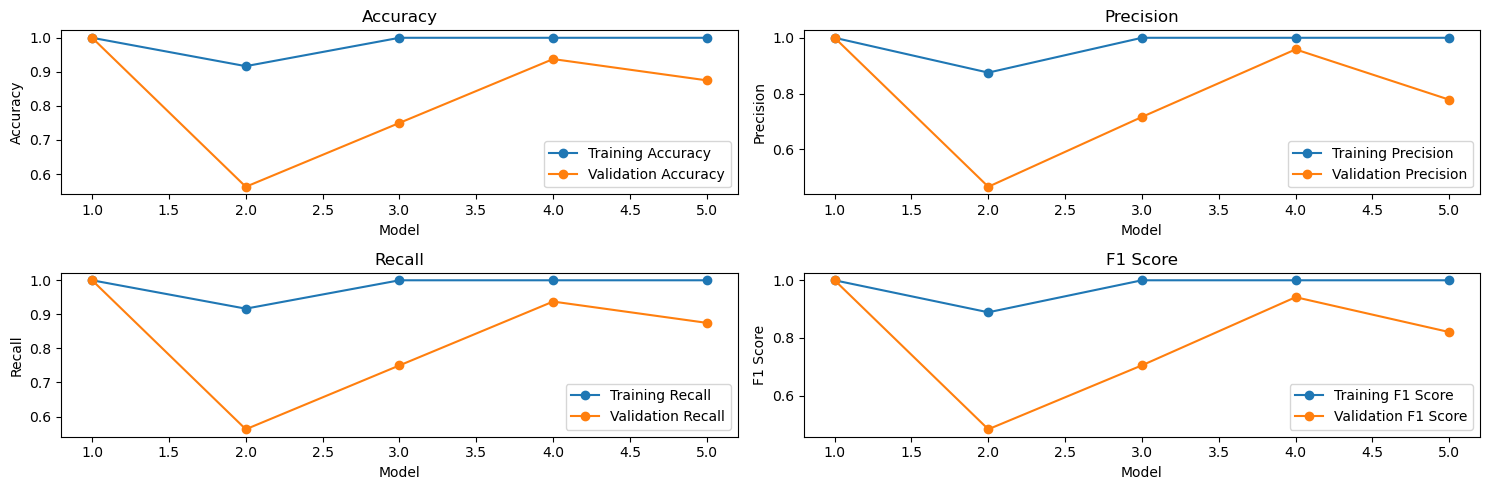

Metrics for Model 1:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Metrics for Model 2:
Accuracy: 0.5625
Precision: 0.4652777777777778
Recall: 0.5625
F1 Score: 0.48295454545454547


Metrics for Model 3:
Accuracy: 0.75
Precision: 0.7159090909090908
Recall: 0.75
F1 Score: 0.7048611111111112


Metrics for Model 4:
Accuracy: 0.9375
Precision: 0.9583333333333334
Recall: 0.9375
F1 Score: 0.9413461538461538


Metrics for Model 5:
Accuracy: 0.875
Precision: 0.7777777777777778
Recall: 0.875
F1 Score: 0.8203125




In [21]:
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Splitting the training data into 5 subsets
X_splits, Y_splits = custom_bootstrap_split(X_train, Y_train, num_splits=5, random_state=None)

# list to hold base models
base_models = []

#lists to store error metrics for each model
accuracy_train_scores = []
precision_train_scores = []
recall_train_scores = []
f1_train_scores = []

accuracy_val_scores = []
precision_val_scores = []
recall_val_scores = []
f1_val_scores = []

#figure for visualizing the training dataset for each model
plt.figure(figsize=(15, 5))

# unique colors for each class label
class_colors = {
    'Iris-setosa': 'red',
    'Iris-versicolor': 'green',
    'Iris-virginica': 'blue'
}

# Training each base model on one of the subsets
for i in range(5):
    classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
    classifier.fit(X_splits[i], Y_splits[i])
    classifier.save_tree_as_dot(f"decision_tree{i+1}.dot")
    base_models.append(classifier)
    
    # Calculate training error
    Y_train_pred = classifier.predict(X_splits[i])
    
    # Calculate accuracy
    accuracy_train = accuracy_score(Y_splits[i], Y_train_pred)
    accuracy_train_scores.append(accuracy_train)
    
    # Calculate precision
    precision_train = precision_score(Y_splits[i], Y_train_pred, average='weighted')
    precision_train_scores.append(precision_train)
    
    # Calculate recall
    recall_train = recall_score(Y_splits[i], Y_train_pred, average='weighted')
    recall_train_scores.append(recall_train)
    
    # Calculate F1 score
    f1_train = f1_score(Y_splits[i], Y_train_pred, average='weighted')
    f1_train_scores.append(f1_train)
    
    # Calculate validation error
    Y_val_pred = classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy_val = accuracy_score(Y_test, Y_val_pred)
    accuracy_val_scores.append(accuracy_val)
    
    # Calculate precision
    precision_val = precision_score(Y_test, Y_val_pred, average='weighted')
    precision_val_scores.append(precision_val)
    
    # Calculate recall
    recall_val = recall_score(Y_test, Y_val_pred, average='weighted')
    recall_val_scores.append(recall_val)
    
    # Calculate F1 score
    f1_val = f1_score(Y_test, Y_val_pred, average='weighted')
    f1_val_scores.append(f1_val)
    
    # subplots for each model
    plt.subplot(1, len(X_splits), i + 1)
    
    # Visualize the training dataset for the current model
    X_i = X_splits[i]
    Y_i = Y_splits[i]
    plt.scatter([sample[0] for sample in X_i], [sample[1] for sample in X_i], c=[class_colors[label[0]] for label in Y_i])
    plt.title(f"Model {i+1} Training Dataset")

# Show the figures
plt.tight_layout()
plt.show()

# Create a figure for visualizing training and validation errors
plt.figure(figsize=(15, 5))

# Subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(range(1, 6), accuracy_train_scores, marker='o', label='Training Accuracy')
plt.plot(range(1, 6), accuracy_val_scores, marker='o', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for precision
plt.subplot(2, 2, 2)
plt.plot(range(1, 6), precision_train_scores, marker='o', label='Training Precision')
plt.plot(range(1, 6), precision_val_scores, marker='o', label='Validation Precision')
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.legend()

# Subplot for recall
plt.subplot(2, 2, 3)
plt.plot(range(1, 6), recall_train_scores, marker='o', label='Training Recall')
plt.plot(range(1, 6), recall_val_scores, marker='o', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.legend()

# Subplot for F1 score
plt.subplot(2, 2, 4)
plt.plot(range(1, 6), f1_train_scores, marker='o', label='Training F1 Score')
plt.plot(range(1, 6), f1_val_scores, marker='o', label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.legend()

# Show the figure
plt.tight_layout()
plt.show()

# Printing the metrics for each model
for i, model in enumerate(base_models):
    print(f"Metrics for Model {i+1}:")
    print(f"Accuracy: {accuracy_val_scores[i]}")
    print(f"Precision: {precision_val_scores[i]}")
    print(f"Recall: {recall_val_scores[i]}")
    print(f"F1 Score: {f1_val_scores[i]}")
    print("\n")
    


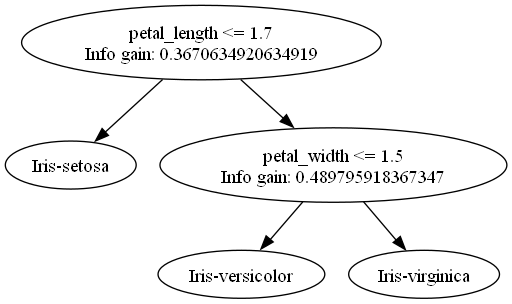

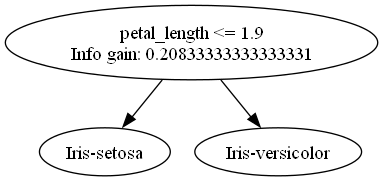

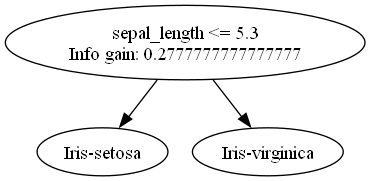

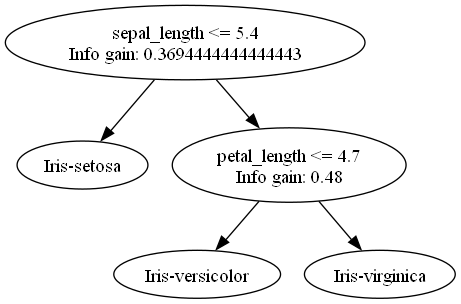

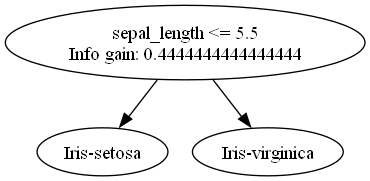

In [22]:
import os
from IPython.display import Image

dot_files_dir = os.path.expanduser("~/")

for i in range(5): 
    dot_file_path = os.path.join(dot_files_dir, f"decision_tree{i+1}.dot")
    png_file_path = os.path.join(dot_files_dir, f"decision_tree{i+1}.png")

    os.system(f"dot -Tpng {dot_file_path} -o {png_file_path}")

    display(Image(filename=png_file_path))


In [23]:
# Lists to store predictions from each model
model_predictions = []

for model in base_models:
    # Make predictions on the test set for each model
    Y_test_pred = model.predict(X_test)
    model_predictions.append(Y_test_pred)

# Initialize an empty list to store final aggregated predictions
aggregated_predictions = []

# Perform majority voting
for ensemble_samples in zip(*model_predictions):
    # Create a dictionary to count the occurrences of each class label
    class_counts = {}
    
    for label in ensemble_samples:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    # Find the label with the majority vote
    majority_vote = max(class_counts, key=class_counts.get)
    
    aggregated_predictions.append(majority_vote)

# Calculate aggregated metrics
accuracy = accuracy_score(Y_test, aggregated_predictions)
precision = precision_score(Y_test, aggregated_predictions, average='weighted')
recall = recall_score(Y_test, aggregated_predictions, average='weighted')
f1 = f1_score(Y_test, aggregated_predictions, average='weighted')

print("Aggregated Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Aggregated Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
